# 📡 Имитационное моделирование RFID-системы для изучения команды `QueryAdjust`

В этом блокноте проводится имитационное моделирование RFID-системы с целью анализа влияния различных параметров на **вероятность** и **время чтения** банка памяти `USER`, в контексте работы команды `QueryAdjust`.

Команда `QueryAdjust` позволяет **изменять параметр `Q` во время текущего раунда инвентаризации**. Она обладает рядом важных особенностей:

---

## 🔧 Особенности команды `QueryAdjust`

1. **Изменение значения `Q` на ±1**
   Каждая команда `QueryAdjust` может:
   - Увеличить `Q` на 1;
   - Уменьшить `Q` на 1;
   - Оставить `Q` без изменений.

2. **Множественные `QueryAdjust` в одном раунде**
   Команда `QueryAdjust` может быть вызвана **сколько угодно раз в пределах одного раунда** инвентаризации.

3. **Изменение количества слотов на лету**
   Использование `QueryAdjust` немедленно **пересчитывает общее количество слотов** в текущем раунде. Пример:

   - Начало раунда: `Q = 3` → 2³ = **8 слотов**
   - После 5 слотов вызывается `QueryAdjust`, которая **увеличивает `Q` на 1**
   - Новое значение `Q = 4` → 2⁴ = **16 слотов**
   - Продолжение раунда: начинается **новый слот в рамках новых 16 слотов**
   - Итого в раунде будет **5 + 16 = 21 слот**

4. **Аналогичное поведение при уменьшении `Q`**
   Если `QueryAdjust` уменьшает `Q`, также происходит немедленный пересчёт числа оставшихся слотов.

5. **Ограничения по диапазону `Q`**
   Команда не может установить `Q` вне допустимого диапазона:
   `0 ≤ Q ≤ 15`.

---

🔍 Это моделирование помогает проанализировать, как использование `QueryAdjust` может влиять на производительность RFID-системы в динамических сценариях.

### Импорт необходимых модулей

In [13]:
from pysim.experiments.utility.rfid_helper import *
from pysim.models.rfid.params import default_params

In [14]:
SAVE_FIG = True         # Сохранять ли изображения
SAVE_RESULTS = False    # Сохранять ли результаты в JSON
USE_JSON = not SAVE_RESULTS        # Использовать ли результаты из JSON

IMG_DIRECTORY = "rfid/adjust/"
JSON_DIRECTORY = "../results/result_jsons/rfid/adjust/"

## 📈 Зависимость вероятности чтения банка памяти `USER` от значения параметра `Q`. Случай без коллизий и без использования QueryAdjust
🔍 **Вариации параметров:**
- Изменяется переменная `Q` от **0 до 15** с шагом 1.
- Построены кривые для разных значений `M` и `Tari`.

🎛 **Перебираемые параметры модуляции (`M`) и длительности импульса (`Tari`):**
- M = `FM0`, Tari = 6.25 мкс
- M = `FM0`, Tari = 18.75 мкс
- M = `Miller-2`, Tari = 12.5 мкс
- M = `Miller-4`, Tari = 6.25 мкс
- M = `Miller-8`, Tari = 25.0 мкс

Как хорошо видно из результатов, при небольших значениях `Q` разницы в величине вероятности почти нет. Начиная с Q = 7 вероятность чтения начинает стремительно уменьшаться из-за того, что раунд заполняется пустыми слотами и становится слишком длинным. В результате этого метка успевает принять участие в меньшем количестве раундов инвентаризации и вероятность снижается.

In [15]:
q_variable = np.arange(0, 16, 1)
coding_params = [
    {"encoding": "FM0", "tari": 6.25},
    {"encoding": "FM0", "tari": 18.75},
    {"encoding": "M2", "tari": 12.5},
    {"encoding": "M4", "tari": 6.25},
    {"encoding": "M8", "tari": 25.0},
]

q_params_list = []
for coding_params_item in coding_params:
    q_params_list.append({
        "tari": coding_params_item["tari"],
        "encoding": coding_params_item["encoding"],
        "tid_word_size": default_params.tid_word_size,
        "power": default_params.power_dbm,
        "num_tags": 1500, # default_params.num_tags,
        "speed": default_params.speed,
        "reader_offset": default_params.reader_offset,
        "tag_offset": default_params.tag_offset,
        "altitude": 4,
        "useadjust": default_params.useadjust,
        "generation_interval": (generation_interval, 1.0)

    })

### 💾 Получение результатов

In [16]:
key_name = lambda params: f"M = {params['encoding']}, Tari = {params['tari']} µs"

In [17]:
q_result = calculate_simulations(
    variable="q",
    variable_values=q_variable,
    params_list=q_params_list,
    key_fn=key_name,
    use_json=USE_JSON,
    save_results=SAVE_RESULTS,
    json_directory=JSON_DIRECTORY,
    file_name="q.json"
)
# Моделирование на M3 Pro с "num_tags": 1500:
# Моделирование по переменной q: 100%|██████████| 5/5 [19:40<00:00, 236.15s/it]

### 🖼️ Построение графика для вероятности чтения банка памяти USER

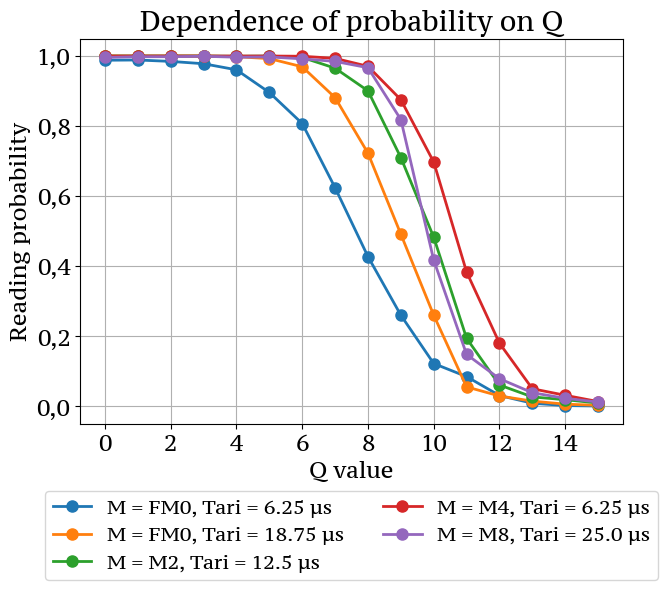

In [18]:
plot_simulations_results(
    results_list=[q_result["read_user_probs"]],
    labels_list=[key_name(params) for params in coding_params],
    titles=["Dependence of probability on Q"],
    x_variable=q_variable,
    x_label="Q value",
    y_label="Reading probability",
    image_name="Q probs",
    save_fig=SAVE_FIG,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)

### 🖼️ Построение графика для времени чтения банка памяти USER

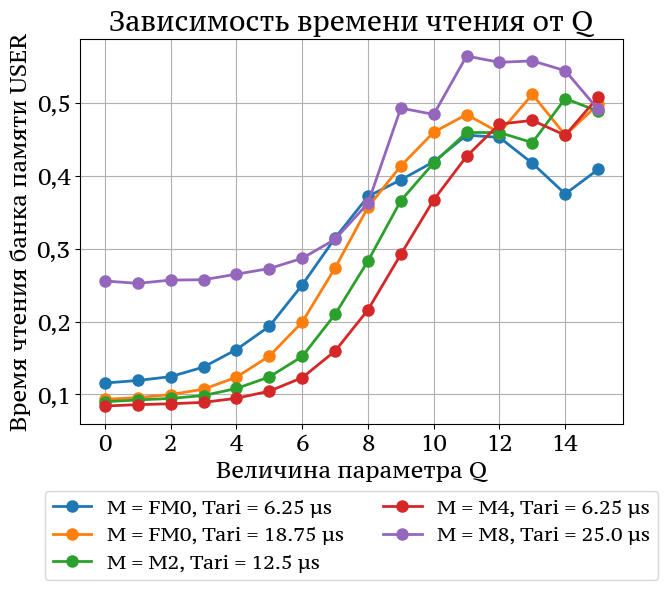

In [19]:
plot_simulations_results(
    results_list=[q_result["times_count"]],
    labels_list=[key_name(params) for params in coding_params],
    titles=["Зависимость времени чтения от Q"],
    x_variable=q_variable,
    x_label="Величина параметра Q",
    y_label="Время чтения банка памяти USER",
    image_name="Q time",
    save_fig=SAVE_FIG,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)

## 📈 Зависимость вероятности чтения банка памяти `USER` от значения параметра `Q` в случае **с коллизиями** и без использования QueryAdjust
🔍 **Вариации параметров:**
- Изменяется переменная `Q` от **0 до 15** с шагом 1.
- Построены кривые для разного количества меток в зоне действия считывателя.



В случае появления нескольких меток в зоне чтения возникает явление коллизий. В результате чего при малых `Q` практически все метки попадают в коллизию и не могут быть считаны. Значения вероятности в таком случае примерно равны нулю. При увеличении `Q` у меток снижается вероятность попадения в коллизию, в результате чего вероятность чтения увеличивается. При этом при слишком больших значениях `Q` метки вынуждены слишком долго ждать своей очереди и вероятность чтения снова снижается.

In [20]:
TAGS_IN_READING_ZONE = (1, 5, 15, 25)

tag_intervals = [
    estimate_generation_interval(tags_amount, compute_reading_zone())
    for tags_amount in TAGS_IN_READING_ZONE
]
tag_period_params = [
    {"label": f"{n} tag(s)", "generation_interval": (generation_interval, t)}
    for n, t in zip(TAGS_IN_READING_ZONE, tag_intervals)
]

### ⚙️ Параметры для разных кривых

In [21]:
q_variable = np.arange(0, 16, 1)
colllision_params_list = []

for tag_params_item in tag_period_params:
    colllision_params_list.append({
        "tari": default_params.tari,
        "encoding":  default_params.encoding,
        "tid_word_size": default_params.tid_word_size,
        "power": default_params.power_dbm,
        "num_tags": 1500,
        "speed": default_params.speed,
        "reader_offset": default_params.reader_offset,
        "tag_offset": default_params.tag_offset,
        "altitude": 4,
        "useadjust": False,
        "generation_interval": tag_params_item["generation_interval"],
        "tags_amount": int(tag_params_item["label"].split()[0]),
        "label": tag_params_item["label"]
    })

### 💾 Получение результатов

In [22]:
key_name = lambda params: f"{params['label']}"

In [23]:
collision_result = calculate_simulations(
    variable="q",
    variable_values=q_variable,
    params_list=colllision_params_list,
    key_fn=key_name,
    use_json=USE_JSON,
    save_results=SAVE_RESULTS,
    json_directory=JSON_DIRECTORY,
    file_name="q_collision.json"
)
# Моделирование на M3 Pro с "num_tags": 1500:
# Моделирование по переменной q: 100%|██████████| 4/4 [10:05<00:00, 151.27s/it]

### 🖼️ Построение графика для вероятности чтения банка памяти USER

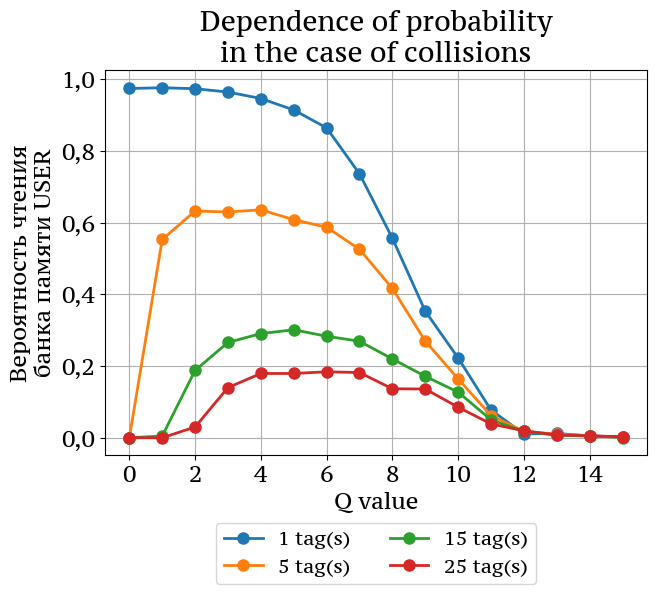

In [24]:
plot_simulations_results(
    results_list=[collision_result["read_user_probs"]],
    labels_list=[key_name(params) for params in tag_period_params],
    titles=["Dependence of probability\nin the case of collisions"],
    x_variable=q_variable,
    x_label="Q value",
    image_name="Collision probs",
    save_fig=SAVE_FIG,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)

### 🖼️ Построение графика для времени чтения банка памяти USER

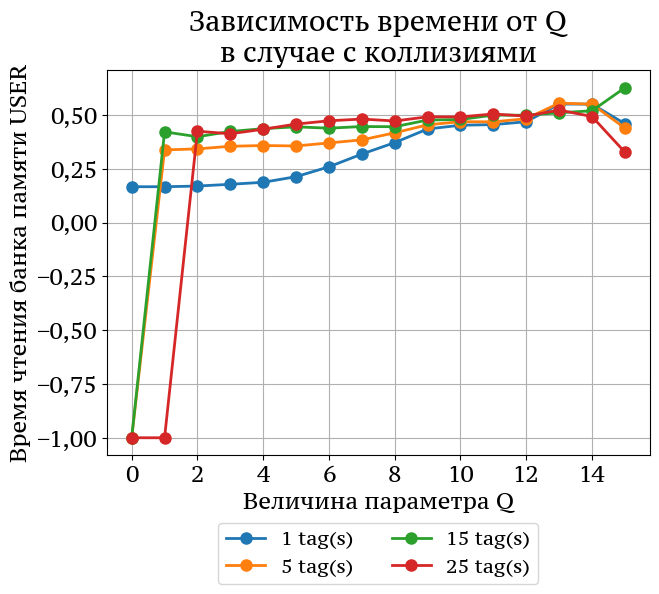

In [25]:
plot_simulations_results(
    results_list=[collision_result["times_count"]],
    labels_list=[key_name(params) for params in tag_period_params],
    titles=["Зависимость времени от Q\nв случае с коллизиями"],
    x_variable=q_variable,
    x_label="Величина параметра Q",
    y_label="Время чтения банка памяти USER",
    image_name="Collision times",
    save_fig=SAVE_FIG,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)

## 📈 Зависимость вероятности чтения банка памяти `USER` от стартового значения параметра `Q`
### 🧪 Сценарий: с коллизиями и использованием алгоритма `QueryAdjust`

---

### 🔍 Вариации параметров

- Перебирается переменная `Q` от **0 до 15** с шагом 1
- Построены кривые для различных **количеств меток в зоне действия считывателя**

---

### ⚙️ Поведение при использовании `QueryAdjust`

При активации алгоритма `QueryAdjust` наблюдается **слабая зависимость результатов от начального значения `Q`**. Это объясняется тем, что:

- В процессе симуляции алгоритм **быстро адаптирует `Q`**, приближая его к оптимальному значению.
- Алгоритм отслеживает количество **коллизий** и **пустых слотов**, соответственно увеличивая или уменьшая `Q`.
- Таким образом, **значение `Q` динамически меняется на протяжении всей симуляции**, а начальное значение почти не влияет на итоговую вероятность чтения.

---

### 🧭 Стратегии использования флагов сессий

Эффективность идентификации меток в условиях коллизий сильно зависит от **стратегии управления флагами `Target`**. В данной симуляции рассматриваются две базовые стратегии:

#### 1. `const` – постоянный `Target`
- Флаг `Target` **не меняется от раунда к раунду**
- Подходит для сценариев с **большим количеством меток** (10 и более)
- Прочитанные метки временно не участвуют, пока вручную не сброшены

#### 2. `switch` – поочерёдное переключение `Target`
- Считыватель **инвертирует `Target` в каждом новом раунде**
- Эффективен при **малом количестве меток** (менее 10)
- После идентификации метка меняет свой `Target`
- Если считыватель не инвертирует `Target`, уже прочитанная метка не будет снова участвовать в следующем раунде

⛔ При большом количестве меток стратегия `switch` теряет эффективность:
метки, попавшие в коллизию, не отвечают, не инвертируют `Target`, и **выпадают из следующих раундов**.

---

### 🧠 Перспективы оптимизации

Для более сложных сценариев с десятками или сотнями меток в зоне чтения необходимо:

- Использовать **комбинированные стратегии флагов `Target` и сессий**
- Применять **интеллектуальные алгоритмы адаптации `Q`**
- Использовать дополнительные команды, например, `NAK`
  (🔧 **не реализовано** в текущей модели)

🔬 Эти аспекты **не исследуются в текущем проекте**.

---

### ⚙️ Параметры для разных кривых

In [26]:
TAGS_IN_READING_ZONE = (1, 5, 25)

tag_intervals = [
    estimate_generation_interval(tags_amount, compute_reading_zone())
    for tags_amount in TAGS_IN_READING_ZONE
]
tag_period_params = [
    {"label": f"{n} меток", "generation_interval": (generation_interval, t)}
    for n, t in zip(TAGS_IN_READING_ZONE, tag_intervals)
]

In [27]:
for tag_params_item in colllision_params_list:
    tag_params_item["useadjust"] = True
    if tag_params_item["tags_amount"] > 10:
        tag_params_item["target_strategy"] = "const"

### 💾 Получение результатов

In [28]:
key_name = lambda params: f"{params['label']}"

In [29]:
collision_result = calculate_simulations(
    variable="q",
    variable_values=q_variable,
    params_list=colllision_params_list,
    key_fn=key_name,
    use_json=USE_JSON,
    save_results=SAVE_RESULTS,
    json_directory=JSON_DIRECTORY,
    file_name="q_collision_adjust.json"
)
# Моделирование на M3 Pro с "num_tags": 1500:
# Моделирование по переменной q: 100%|██████████| 4/4 [07:13<00:00, 108.45s/it]

### 🖼️ Построение графика для вероятности чтения банка памяти USER

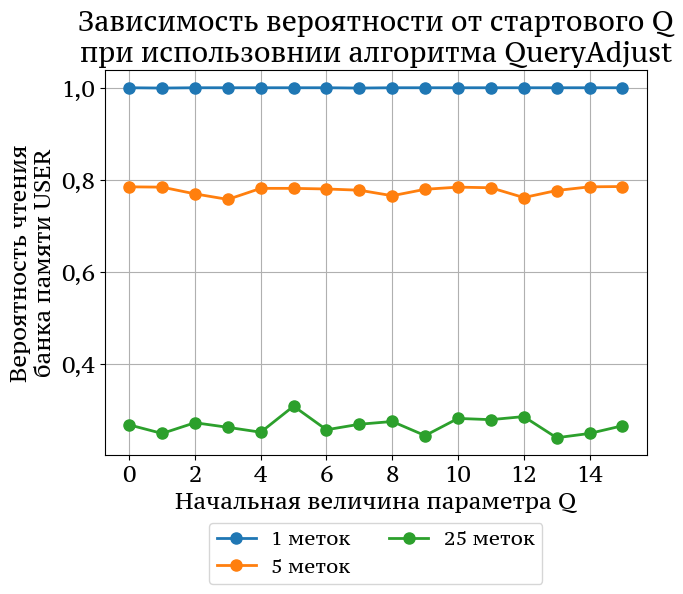

In [30]:
plot_simulations_results(
    results_list=[collision_result["read_user_probs"]],
    labels_list=[key_name(params) for params in tag_period_params],
    titles=["Зависимость вероятности от стартового Q\nпри использовнии алгоритма QueryAdjust"],
    x_variable=q_variable,
    x_label="Начальная величина параметра Q",
    image_name="Collision probs QAdjust",
    save_fig=True,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)

### 🖼️ Построение графика для времени чтения банка памяти USER

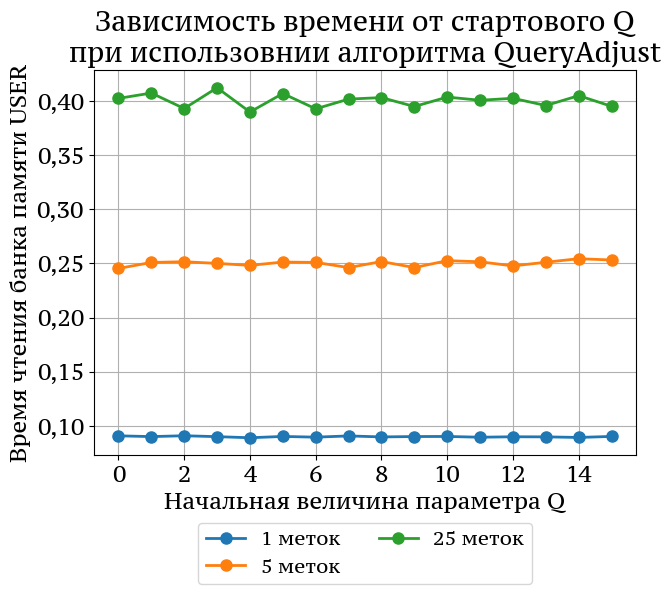

In [31]:
plot_simulations_results(
    results_list=[collision_result["times_count"]],
    labels_list=[key_name(params) for params in tag_period_params],
    titles=["Зависимость времени от стартового Q\nпри использовнии алгоритма QueryAdjust"],
    x_variable=q_variable,
    x_label="Начальная величина параметра Q",
    y_label="Время чтения банка памяти USER",
    image_name="Collision times QAdjust",
    save_fig=SAVE_FIG,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)